# Prep

In [ ]:
!pip install ultralytics

In [2]:
import os
import shutil
import time
from google.colab import drive

# ==========================================
# 1. MOUNT DRIVE (The "Vault")
# ==========================================
# This gives access to your permanent storage
drive.mount('/content/drive')

# Paths
DRIVE_ZIP_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/trainxs.zip'
LOCAL_ZIP_PATH = '/content/trainxs.zip'
LOCAL_DATA_DIR = '/content/data_local'
GCP_KEY_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/colab-upload-bot-key.json'
LOCAL_GCP_KEY_PATH = '/content/colab-upload-bot-key.json'
ANNOTATION_PATH = '/content/drive/MyDrive/Oxford/study/VIS/phase_1/annotations/train.json'
LOCAL_ANNOTATION_PATH = '/content/train.json'

# ==========================================
# 2. COPY & UNZIP (The Speed Hack)
# ==========================================

shutil.copy(GCP_KEY_PATH, LOCAL_GCP_KEY_PATH)
shutil.copy(ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)

if not os.path.exists(LOCAL_DATA_DIR):
    print("🚀 Copying data from Drive to Local SSD (Fast)...")
    t0 = time.time()

    # Copy the ZIP from Drive to Colab Local Disk
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)

    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    # Unzip quietly (-q) to avoiding spamming output
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')

    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")
else:
    print("✅ Data already loaded locally.")

# ==========================================
# 3. CONFIGURE YOUR STRATEGY
# ==========================================
# Point your existing code to look at the LOCAL folder, not Drive
TRAIN_DIR = os.path.join(LOCAL_DATA_DIR, 'trainxs')
# (Make sure this matches the folder structure inside your zip)

Mounted at /content/drive
🚀 Copying data from Drive to Local SSD (Fast)...
📦 Unzipping... (This is fast on Colab SSD)
✅ Data Ready! Setup took: 75.74s


# Run the Pipeline

In [11]:
# ==========================================
# 4. SETUP & IMPORTS
# ==========================================
import glob
import torch
import torchvision
import cv2
import json
import sys
import pandas as pd
import warnings
import math
from collections import defaultdict
import re

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 5. CONFIGURATION
# ==========================================
OUTPUT_CSV_PATH = './baseline_tiled_gpu.csv'
SHOULD_LIMIT_VIDEO = 1
# Set if SHOULD_LIMIT_VIDEO == 1
VIDEO_INDEX = 1

# We stick to s6 (Large Image model) but feed it smaller crops
MODEL_NAME = 'yolov5s6'
IMG_SIZE = 1280
# Lower conf to catch tiny birds, rely on Class Filter to stop noise
CONF_THRESH = 0.01
IOU_THRESH = 0.45

print(f"⏳ Loading Model: {MODEL_NAME}...")
try:
    model = torch.hub.load('ultralytics/yolov5', MODEL_NAME, pretrained=True, force_reload=False)
    model.conf = CONF_THRESH

    # --- CRITICAL FIX: Only look for Birds ---
    # 14: Bird, 4: Airplane (sometimes birds look like planes)
    model.classes = [14]

    if torch.cuda.is_available():
        device = torch.device('cuda')
        print("✅ Model Loaded on GPU.")
    else:
        device = torch.device('cpu')
        print("⚠️ Model Loaded on CPU.")

    model.to(device)
except Exception as e:
    print(f"❌ Model Load Error: {e}")

# ==========================================
# 6. HELPER FUNCTIONS
# ==========================================
def load_json_ground_truth(json_path):
    if not os.path.exists(json_path):
        return {}

    print(f"📂 Parsing annotations from: {json_path}...")
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"❌ JSON Parse Error: {e}")
        return {}

    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])

    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename
        if key.startswith('train/'):
            key = key.replace('train/', '', 1)
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])

    print(f"✅ Loaded GT for {len(filename_to_gt)} images.")
    return filename_to_gt

def get_center(box):
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = re.compile(rf"^{re.escape(name)}_(\d+){re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = pattern.match(f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

# ==========================================
# 7. TILING LOGIC (Upgraded to 6x4 Grid)
# ==========================================
def get_tiled_predictions(model, img, img_size, device):
    """
    Splits image into a 6x4 Grid.
    4K (3840x2160) -> 640x540 crops.
    This creates smaller chunks to force the model to look at details.
    """
    h, w, _ = img.shape

    # Grid Configuration: 6 Cols x 4 Rows
    N_COLS = 6
    N_ROWS = 4

    h_step = h // N_ROWS
    w_step = w // N_COLS

    # Overlap (20% - Increased to prevent cutting birds in half)
    h_over = int(h_step * 0.20)
    w_over = int(w_step * 0.20)

    crops = []
    offsets = []

    for r in range(N_ROWS):
        for c in range(N_COLS):
            # Calculate coordinates with overlap
            y1 = max(0, r * h_step - h_over)
            x1 = max(0, c * w_step - w_over)
            y2 = min(h, (r + 1) * h_step + h_over)
            x2 = min(w, (c + 1) * w_step + w_over)

            crops.append(img[y1:y2, x1:x2])
            offsets.append((x1, y1))

    # Batch Inference
    all_boxes = []
    all_scores = []

    # Process in chunks of 8 (since we have 24 tiles total now)
    CHUNK_SIZE = 8

    for i in range(0, len(crops), CHUNK_SIZE):
        sub_crops = crops[i : i + CHUNK_SIZE]
        sub_offsets = offsets[i : i + CHUNK_SIZE]

        # Run YOLO
        results = model(sub_crops, size=img_size)

        for j, det in enumerate(results.xyxy):
            if det is not None and len(det) > 0:
                det = det.clone()
                x_off, y_off = sub_offsets[j]

                # Map coords back to full 4K image
                det[:, 0] += x_off
                det[:, 1] += y_off
                det[:, 2] += x_off
                det[:, 3] += y_off

                all_boxes.append(det[:, :4])
                all_scores.append(det[:, 4])

    if not all_boxes: return []

    # NMS to merge overlapping boxes from different tiles
    pred_boxes = torch.cat(all_boxes, dim=0)
    pred_scores = torch.cat(all_scores, dim=0)
    keep_indices = torchvision.ops.nms(pred_boxes, pred_scores, iou_threshold=0.45)
    final_tensor = pred_boxes[keep_indices]

    final_preds = []
    final_tensor = final_tensor.cpu().numpy()
    for box in final_tensor:
        x1, y1, x2, y2 = box
        final_preds.append([x1, y1, x2-x1, y2-y1])

    return final_preds

# ==========================================
# 8. OPTIMIZED BATCHED PIPELINE
# ==========================================
def run_baseline_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()

    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if VIDEO_INDEX < len(video_folders) and SHOULD_LIMIT_VIDEO == 1:
        video_folders = [video_folders[VIDEO_INDEX]]
      else:
        video_folders = video_folders[:SHOULD_LIMIT_VIDEO]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting Batched Inference (6x4 Tiling)...")

    total_tp = total_fp = total_fn = total_time_sec = total_frames = 0
    results_data = []

    # Process 1 frame at a time (since 1 frame now = 24 tiles, we can't batch frames easily on T4)
    BATCH_SIZE = 1

    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6}")
    print("-" * 65)

    for v_idx, video_path in enumerate(video_folders):
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)

        for i, img_path in enumerate(images):
            # Progress
            if i % 10 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            img = cv2.imread(img_path)
            if img is None: continue

            # --- TILING INFERENCE ---
            preds = get_tiled_predictions(model, img, IMG_SIZE, device)

            # Evaluation (Center Distance)
            img_filename = os.path.basename(img_path)
            key = f"{video_name}/{img_filename}"
            gts = gt_data.get(key, [])

            matched_gt = set()
            for p_box in preds:
                best_dist = 10000
                best_idx = -1
                for g_idx, g_box in enumerate(gts):
                    if g_idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist:
                        best_dist = d
                        best_idx = g_idx

                # Threshold: 30px distance
                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1
            vid_fn += len(gts) - len(matched_gt)

        # Stats
        vid_end = time.time()
        vid_time = vid_end - vid_start
        vid_fps = n_frames / vid_time if vid_time > 0 else 0

        total_time_sec += vid_time
        total_frames += n_frames
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {n_frames:<6} | {vid_fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f}")

        results_data.append({
            'Video': video_name, 'Frames': n_frames, 'FPS': round(vid_fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn
        })

    print("=" * 65)
    avg_fps = total_frames / total_time_sec if total_time_sec > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("FINAL RESULTS (6x4 Tiling + Filtered):")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    final_path = get_next_version_path(OUTPUT_CSV_PATH)
    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")
    print(f"⏱️ Process took: {time.time() - start_time:.2f} seconds")

if __name__ == "__main__":
    run_baseline_evaluation()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-24 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 


⏳ Loading Model: yolov5s6...


YOLOv5s6 summary: 280 layers, 12612508 parameters, 0 gradients, 16.8 GFLOPs
Adding AutoShape... 


✅ Model Loaded on GPU.
📂 Parsing annotations from: /content/train.json...
✅ Loaded GT for 52680 images.
📂 Found 1 videos. Starting Batched Inference (6x4 Tiling)...

Video      | Frames | FPS    | Prec   | Recall | F1    
-----------------------------------------------------------------
0002       | 597    | 1.1    | 0.54   | 0.63   | 0.58  
FINAL RESULTS (6x4 Tiling + Filtered):
Total Frames:   597
Average FPS:    1.05
Precision:      0.5373
Recall:         0.6330
F1-Score:       0.5812
✅ CSV Saved: ./baseline_tiled_gpu_2.csv
⏱️ Process took: 567.59 seconds


# Debug

🎯 Limiting Visualization to ONLY Video Index: 1
📂 Parsing annotations from: /content/train.json...
✅ Loaded GT for 52680 images.
🕵️ Starting Scan across 1 videos...

🎬 VIDEO 1/1: 0002
   Scanning frame 0/597...
   📸 Frame 0: ✅ HIT (Accurate Detection)


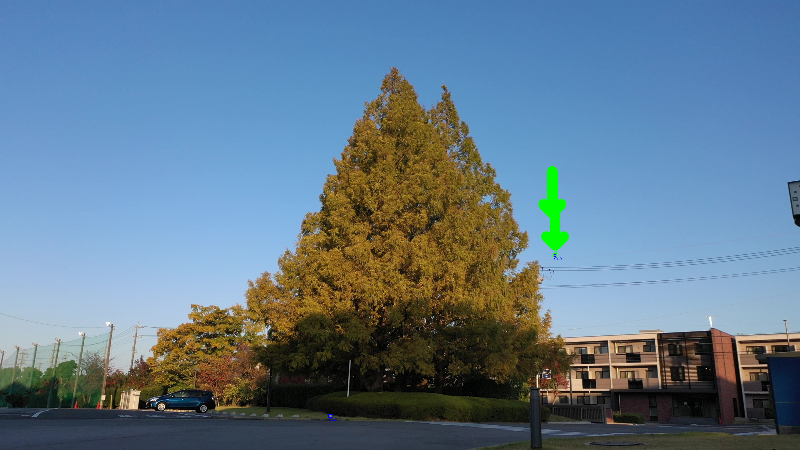

   Scanning frame 70/597...
   📸 Frame 70: ⚠️ DISTRACTION (Predicted wrong object)


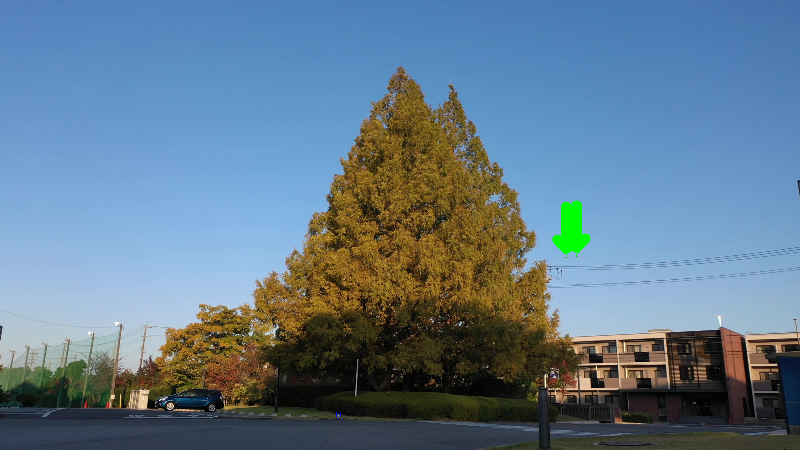

   ✅ Found examples. Moving to next video.


In [19]:
# ==========================================
# SMART VISUALIZATION (BASELINE - LIMIT RESPECTED)
# ==========================================
from google.colab.patches import cv2_imshow

def boxes_intersect(boxA, boxB):
    ax1, ay1, ax2, ay2 = boxA[0], boxA[1], boxA[0]+boxA[2], boxA[1]+boxA[3]
    bx1, by1, bx2, by2 = boxB[0], boxB[1], boxB[0]+boxB[2], boxB[1]+boxB[3]
    if (ax1 > bx2) or (ax2 < bx1) or (ay1 > by2) or (ay2 < by1): return False
    return True

def draw_arrow_pointer(img, x, y, w, h, color=(0, 255, 0)):
    """Draws a GIANT arrow pointing to the box center with a safety gap."""
    center_x = int(x + w // 2)
    gap = 40       # Gap between arrow tip and box
    arrow_len = 200 # Longer body to balance the thickness

    # Decide direction: Default point down from top.
    if y < (gap + arrow_len):
        start_point = (center_x, y + h + gap + arrow_len)
        end_point = (center_x, y + h + gap)
    else:
        start_point = (center_x, y - gap - arrow_len)
        end_point = (center_x, y - gap)

    # Thickness 50px
    cv2.arrowedLine(img, start_point, end_point, color, thickness=50, tipLength=0.3)

def visualize_baseline_smart_all_videos():
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]

    # --- FILTERING LOGIC (MATCHES CELL 2) ---
    if SHOULD_LIMIT_VIDEO:
        if SHOULD_LIMIT_VIDEO == 1 and VIDEO_INDEX < len(video_folders):
            print(f"🎯 Limiting Visualization to ONLY Video Index: {VIDEO_INDEX}")
            video_folders = [video_folders[VIDEO_INDEX]]
        else:
            print(f"🎯 Limiting Visualization to first {SHOULD_LIMIT_VIDEO} videos.")
            video_folders = video_folders[:SHOULD_LIMIT_VIDEO]
    # ----------------------------------------

    if not video_folders:
        print("❌ No videos found.")
        return

    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    print(f"🕵️ Starting Scan across {len(video_folders)} videos...")

    for v_idx, target_video in enumerate(video_folders):
        video_name = os.path.basename(target_video)
        images = sorted(glob.glob(os.path.join(target_video, '*.jpg')))

        print(f"\n==========================================")
        print(f"🎬 VIDEO {v_idx+1}/{len(video_folders)}: {video_name}")
        print(f"==========================================")

        hit_found = False
        distraction_found = False

        for i in range(0, len(images), 5):
            if hit_found and distraction_found:
                print("   ✅ Found examples. Moving to next video.")
                break

            sys.stdout.write(f"\r   Scanning frame {i}/{len(images)}...")
            sys.stdout.flush()

            frame = cv2.imread(images[i])
            preds = get_tiled_predictions(model, frame, IMG_SIZE, device)

            key = f"{video_name}/{os.path.basename(images[i])}"
            gts = gt_data.get(key, [])

            if not gts and not preds: continue

            # Analyze Overlaps
            has_overlap = False
            has_separation = False

            if len(gts) > 0 and len(preds) > 0:
                overlap_count = 0
                for p in preds:
                    for g in gts:
                        if boxes_intersect(p, g):
                            overlap_count += 1

                if overlap_count > 0: has_overlap = True
                else: has_separation = True

            show_it = False
            label = ""

            if has_overlap and not hit_found:
                show_it = True
                hit_found = True
                label = "✅ HIT (Accurate Detection)"

            elif has_separation and not distraction_found:
                show_it = True
                distraction_found = True
                label = "⚠️ DISTRACTION (Predicted wrong object)"

            if show_it:
                print(f"\n   📸 Frame {i}: {label}")

                # 1. Draw Predictions (Blue)
                for box in preds:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (255, 0, 0), 2)
                    cv2.putText(frame, "YOLO", (x, y+bh+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                # 2. Draw GT (Green) + ARROWS
                for box in gts:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (0, 255, 0), 2)
                    cv2.putText(frame, "GT", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    draw_arrow_pointer(frame, x, y, bw, bh, color=(0, 255, 0))

                # Resize and Show
                h, w = frame.shape[:2]
                if w > 800: frame = cv2.resize(frame, (800, int(h * 800/w)))
                cv2_imshow(frame)

visualize_baseline_smart_all_videos()